# Data organization

## References

https://docs.python.org/3/library/codecs.html#standard-encodings

https://developers.google.com/edu/python/regular-expressions

## Imports

In [1]:
#import warnings
#warnings.filterwarnings("ignore")

import os
import sys

import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

## UDFs

### Generic utilities

In [2]:
# Map a series according to given dictionary
def do_series_mapping(series, mapping_dict):
    
    series = series.map(mapping_dict)
    assert(series.isnull().sum() == 0)
    
    return series

In [3]:
# Read a series as the desired dtype
def read_series_astype(series, dtype):
    
    if dtype == 'object' or dtype == np.str:
        # Example: '5,989E+12'
        series = series.astype(np.str)
        series = pd.Series([val if len(re.findall(r'^\d[\,\d]\d*[Ee]\+\d+$', val)) is not 1
                            else int(float(val.replace(',', '.')))
                            for val in series], index=series.index)
        series = series.astype(dtype)
    else:
        try:
            series = series.astype(dtype)
        except:
            print("Handling exception in read_series_astype...\nunique values:", np.unique(series), 
                 "\ndtype:", dtype, "\n")
            # Example: '9,5'
            series = pd.Series([val.replace(',', '.') for val in series], 
                               index=series.index).astype(dtype)
            
    return series

In [4]:
# Calculate the size of a dictionary in GB
def calc_dict_size(my_dict):
    
    size = sys.getsizeof(my_dict)
    size += sum(map(sys.getsizeof, my_dict.values())) + sum(map(sys.getsizeof, my_dict.keys()))
    print("Size is", size/(10**9), "GB!")

In [5]:
# Handle NaN by filling in with given pattern
def handle_nan_by_filling_in(df, f_name, fill_with):   
    
    num_nan = df.isnull().sum()
    try:   
        # Ensure no NaNs
        assert(num_nan.sum() == 0)
    except:
        print("Handling exception in", f_name, "...num_nan:\n", num_nan, "\n")
        # Fill them with 'Unknown'
        df.fillna(fill_with, inplace=True)
    
    return df

### Utilities for reading an individual file

In [6]:
# Serialize the dataframe into date-wise observations
def serialize_record(df, dates, record_type, DEBUG=False):
    
    # If all the columns in any row of this file have NaNs, drop it
    df.dropna(how='all', inplace=True) 
    
    # Add more meaningful columns
    quantity_col_name = 'Quantity_' + record_type
    df['Date'] = None    
    df[quantity_col_name] = None
    
    # Initialize
    first_valid_date_idx = dates.isnull().sum()
    chunk_to_append = df.copy()

    # Iterate through the dates and serialize accordingly
    for idx, date in enumerate(dates):
        if not pd.isnull(date):
            # Assign the right date and quantity to the chunk_to_append
            chunk_to_append.Date = date
            chunk_to_append[quantity_col_name] = df.iloc[:, idx]

            # Now update the original df
            if idx == first_valid_date_idx:
                df = chunk_to_append.copy()
            else:           
                df = df.append(chunk_to_append, ignore_index=True)

    # Esnure all that we did above is fine
    assert(len(chunk_to_append) * (len(dates) - first_valid_date_idx) == len(df))
    
    # Date-wise columns which originally contained the quantities are no more required - dop them
    to_drop = df.columns[range(first_valid_date_idx, len(dates))]
    df.drop(to_drop, axis=1, inplace=True)
    
    # Now drop rows where no transaction took place
    df.dropna(inplace=True)    

    # Finally, read the Date column as time
    df.Date = pd.to_datetime(df.Date, infer_datetime_format=True)
    
    if DEBUG:
        print("Serialized shape:", df.shape)
    
    return df, quantity_col_name

In [7]:
# Read an individual file containing transactional data (sell_in / sell_out / opening_stock)
def read_transactional_record(record_path, record_type, DEBUG=False, multi_index=True):  
    
    # The 1st row contains the dates which this file has data for
    dates = pd.read_csv(record_path, low_memory=False, sep=';', header=None, nrows=1).iloc[0, :].T    
  
    # Now read the full data in this file, but after skipping the 1st row
    df = pd.read_csv(record_path, low_memory=False, sep=';', skiprows=1)
    
    if DEBUG:
        print("Dates:", dates)
        print("Original shape:", df.shape)
    
    # Serialize the dataframe into date-wise observations
    df, quantity_col_name = serialize_record(df, dates, record_type, DEBUG)
    
    # Have column names in English
    df.columns = ['NAV', 'Retailer', 'SKU', 'Barcode', 'Date', quantity_col_name]
    
    # Quantity for sell_out is stored as a negative number - let's reverse that
    if record_type is 'sell_out':
        df[quantity_col_name] = df[quantity_col_name] * -1
    
    # NAV and Barcode are essentially identifiers for Retailer and SKU respectively - drop them
    df.drop(['NAV', 'Barcode'], axis=1, inplace=True) # TBD: Check if this is ok
    
    # Quantity should be read as float64
    df[quantity_col_name] = read_series_astype(df[quantity_col_name], 'float64')
    
    # Now, read the object or string columns as category, which is more efficient
    cat_cols = ['Retailer', 'SKU']
    for col in cat_cols:
        read_series_astype(df[col], 'category') 
    
    # Handle NaNs by filling in with 'Unknown'
    df = handle_nan_by_filling_in(df, str(read_transactional_record), 'Unknown')

    # Finally, multi-index it by Retailer, SKU and Date
    if multi_index:
        df.set_index(['Retailer', 'SKU', 'Date'], inplace=True)
        df.sort_index(inplace=True)

    if DEBUG:
        print("Final shape:", df.shape)
        print(df.dtypes)
        print(df.head())
    
    return df, quantity_col_name

In [8]:
# Read an individual file containing retailer data
def read_retailer_record(record_path, record_type, DEBUG=False):      

    # Read the full data in this file
    df = pd.read_csv(record_path, low_memory=False, sep=';')

    # Have column names in English
    df.columns = ['NAV', 'Retailer', 'Retailer_name', 'Zipcode', 'City', 'Address', 'Active', 'County']
    
    # NAV and Retailer_name are essentially identifiers for Retailer - drop them
    df.drop(['NAV', 'Retailer_name'], axis=1, inplace=True) # TBD: Check if this is ok
    
    # Zipcode should be read as string, and NOT as integer
    df.Zipcode = read_series_astype(df.Zipcode, np.str)
    
    # Active should be read as bool
    df.Active = read_series_astype(df.Active, 'bool')
    
    # Now, read the object or string columns as category, which is more efficient
    cat_cols = ['Retailer', 'Zipcode', 'City', 'Address', 'County']
    for col in cat_cols:
        read_series_astype(df[col], 'category')
    
    # Handle NaNs by filling in with 'Unknown'
    df = handle_nan_by_filling_in(df, str(read_retailer_record), 'Unknown')

    # Finally, index it by Retailer
    df.set_index('Retailer', inplace=True)
    
    if DEBUG:
        print("Final shape:", df.shape)
        print(df.dtypes)
        print(df.head())
    
    return df

In [9]:
# Translate columns in SKU record according to mapping specified in row_1
def translate_sku_record(df, row_1):
    
    # TBD: Parse row_1 to extrct mappings automatically and then translate them
    product_type_dict = {'1 - Cigaretta': 'Cigarette',
                         '10 - Elektromos cigaretta folyadék': 'Liquid',
                         '2 - Szivar': 'Cigar',
                         '3 - Szivarka': 'Cigarillo',
                         '4 - Finomra vágott fogyasztási dohány (cigarettadohány)': 'Tobacco',      
                         '5 - Egyéb fogyasztási dohány (pipadohány)': 'Pipe tobacco',      
                         '6 - Dohányt tartalmazó kiegészítő': 'OTP accessories',      
                         '7 - Cigarettapapír (lap)': 'Paper',      
                         '8 - Cigarettahüvely': 'Tube',      
                         '9 - Füstszűrő': 'Filter'}       
    df.Product = do_series_mapping(df.Product, product_type_dict)
    
    basic_quantitive_unit_dict = {'g': 'gm',
                                  'ml': 'ml',
                                  'szál': 'stick',
                                  'db': 'piece'}   
    df.Unit_basic = do_series_mapping(df.Unit_basic, basic_quantitive_unit_dict)
    
    return df

In [10]:
# Read an individual file containing SKU data
def read_sku_record(record_path, record_type, DEBUG=False):  
    
    # The 1st row contains mappings for English translation for some of the columns
    row_1 = pd.read_csv(record_path, sep=r'\t', skiprows=1, encoding='iso8859_2', engine='python', 
                        header=None, nrows=1).iloc[0, :].T  
   
    # Read this file using tab separator and West European encoding, after skipping the 1st row
    df = pd.read_csv(record_path, sep=r'\t', skiprows=1, encoding='iso8859_2', engine='python')

    # Have column names in English
    df.columns = ['SKU', 'Barcode', 'Product', 'SKU_short_name', 'Short_name', 'Name', 
                  'Manufacturer', 'Brand', 'Unique',
                  'TAR_mg', 'Nikotin_mg', 'CO_mg', 'Unit_quant', 'Unit_basic']
    
    # Barcode is essentially identifier for SKU and SKU_short_name is juxtaposition of two columns - drop them
    df.drop(['Barcode', 'SKU_short_name'], axis=1, inplace=True) # TBD: Check if this is ok
    
    # TAR_mg should be read as float64
    df.TAR_mg = read_series_astype(df.TAR_mg, 'float64')
    
    # Nikotin_mg should be read as float64
    df.Nikotin_mg = read_series_astype(df.Nikotin_mg, 'float64')
    
    # CO_mg should be read as float64
    df.CO_mg = read_series_astype(df.CO_mg, 'float64')
    
    # Unit_quant should be read as float64
    df.Unit_quant = read_series_astype(df.Unit_quant, 'float64')
    
    # Translate columns according to mapping specified in the 1st row
    df = translate_sku_record(df, row_1)
    
    # Now, read the object or string columns as category, which is more efficient
    cat_cols = ['SKU', 'Product', 'Short_name', 'Name', 'Manufacturer', 'Brand', 'Unique', 'Unit_basic']
    for col in cat_cols:
        read_series_astype(df[col], 'category')
     
    # Handle NaNs by filling in with 'Unknown'
    df = handle_nan_by_filling_in(df, str(read_sku_record), 'Unknown')

    # Finally, index it by SKU
    df.set_index('SKU', inplace=True)
    
    if DEBUG:
        print("Final shape:", df.shape)
        print(df.dtypes)
        print(df.head())
    
    return df

In [11]:
# Read an individual file
def read_record(record_path, record_type, DEBUG=False):
    
    if record_type is 'retailer':
        return read_retailer_record(record_path, record_type, DEBUG)
    elif record_type is 'sku':
        return read_sku_record(record_path, record_type, DEBUG)
    else:
        assert(record_type is 'sell_in' or record_type is 'sell_out' or record_type is 'opening_stock')
        return read_transactional_record(record_path, record_type, DEBUG, multi_index=True)

In [12]:
# Merge dataframes for a specific record date into a single dataframe
def merge_1day_records(left_df, opening_stock=None, sell_in=None, sell_out=None, retailer=None, sku=None, DEBUG=False):
    
    assert(left_df is not None)
    
    if opening_stock is not None:
        left_df = left_df.merge(opening_stock, how='outer', 
                                left_index=True, right_index=True, 
                                copy=False)
    if sell_in is not None:
        left_df = left_df.merge(sell_in, how='outer', 
                                left_index=True, right_index=True, 
                                copy=False)
    if sell_out is not None:
        left_df = left_df.merge(sell_out, how='outer', 
                                left_index=True, right_index=True, 
                                copy=False)
    
    if retailer is not None:
        left_df = left_df.merge(retailer, how='left', left_index=True, right_index=True, copy=False)
    if sku is not None:
        left_df = left_df.merge(sku, how='left', left_index=True, right_index=True, copy=False)
    
    # Handle NaNs by filling in with 0
    left_df = handle_nan_by_filling_in(left_df, str(merge_1day_records), 0)
    
    if DEBUG:
        print("Merged shape:", left_df.shape)
        print(left_df.dtypes)
        print(left_df.head())
        
    return left_df

### Utilities for reading multiple files

In [13]:
# Merge dataframes for different record dates into a single dataframe
def merge_nday_records(left_df, right_df, DEBUG=False):
    
    assert(left_df is not None and right_df is not None)
    
    left_df = pd.concat([left_df, right_df], join='outer', copy=False)
    
    # Handle NaNs by filling in with 0
    left_df = handle_nan_by_filling_in(left_df, str(merge_nday_records), 0)
    
    # Sort the index
    left_df.sort_index(inplace=True)
    
    if DEBUG:
        print("Merged shape:", left_df.shape)
        print(left_df.dtypes)
        print(left_df.head())
        
    return left_df

## Load the data

### Read individual files

#### Opening stock

In [14]:
record_path = "data/Data Fresh/Description/KESZLET_20180709081746.csv"
record_type = 'opening_stock'

In [15]:
opening_stock, _ = read_record(record_path, record_type, DEBUG=True)

Dates: 0            NaN
1            NaN
2            NaN
3            NaN
4     2018.06.29
5     2018.06.30
6     2018.07.01
7     2018.07.02
8     2018.07.03
9     2018.07.04
10    2018.07.05
11    2018.07.06
12    2018.07.07
13    2018.07.08
Name: 0, dtype: object
Original shape: (298089, 14)
Serialized shape: (2786116, 6)
Final shape: (2786116, 1)
Quantity_opening_stock    float64
dtype: object
                                 Quantity_opening_stock
Retailer     SKU     Date                              
HU0001/00009 A003505 2018-06-29                  1800.0
                     2018-06-30                  1800.0
                     2018-07-01                  1600.0
                     2018-07-02                  1600.0
                     2018-07-03                  1600.0


#### Sell in

In [16]:
record_path = "data/Data Fresh/Description/SELLIN_20180709082640.csv"
record_type = 'sell_in'

In [17]:
sell_in, _ = read_record(record_path, record_type, DEBUG=True)

Dates: 0            NaN
1            NaN
2            NaN
3            NaN
4     2018.06.29
5     2018.06.30
6     2018.07.01
7     2018.07.02
8     2018.07.03
9     2018.07.04
10    2018.07.05
11    2018.07.06
12    2018.07.07
13    2018.07.08
Name: 0, dtype: object
Original shape: (101989, 14)
Serialized shape: (139494, 6)
Final shape: (139494, 1)
Quantity_sell_in    float64
dtype: object
                                 Quantity_sell_in
Retailer     SKU     Date                        
HU0001/00009 A004873 2018-07-05             200.0
             A005455 2018-07-05             750.0
             A005466 2018-07-05             400.0
             A005467 2018-07-05             200.0
             A005469 2018-07-05             200.0


#### Sell out

In [18]:
record_path = "data/Data Fresh/Description/SELLOUT_20180709082318.csv"
record_type = 'sell_out'

In [19]:
sell_out, _ = read_record(record_path, record_type, DEBUG=True)

Dates: 0            NaN
1            NaN
2            NaN
3            NaN
4     2018.06.29
5     2018.06.30
6     2018.07.01
7     2018.07.02
8     2018.07.03
9     2018.07.04
10    2018.07.05
11    2018.07.06
12    2018.07.07
13    2018.07.08
Name: 0, dtype: object
Original shape: (195996, 14)
Serialized shape: (743030, 6)
Final shape: (743030, 1)
Quantity_sell_out    float64
dtype: object
                                 Quantity_sell_out
Retailer     SKU     Date                         
HU0001/00009 A003505 2018-06-30              200.0
                     2018-07-07              200.0
             A004283 2018-07-04              200.0
             A004318 2018-07-03              400.0
                     2018-07-08              200.0


#### Retailer

In [20]:
record_path = "data/Data Fresh/Description/VEVO_20180709082824.csv"
record_type = 'retailer'

In [21]:
retailer = read_record(record_path, record_type, DEBUG=True)

Final shape: (5928, 5)
Zipcode    object
City       object
Address    object
Active       bool
County     object
dtype: object
            Zipcode               City            Address  Active    County
Retailer                                                                   
RT/HU0401/1    1094  Budapest 09. ker.      Tompa utca 9.    True  Budapest
RT/HU0395/1    1035  Budapest 03. ker.  Szentendrei út 8.    True  Budapest
RT/HU0394/2    1029  Budapest 02. ker.     Ábránd utca 2.    True  Budapest
RT/HU0401/2    1094  Budapest 09. ker.     Tompa utca 18.    True  Budapest
KJ/HU2495/1    8096             Sukoró  Fehérvári utca 1.    True     Fejér


#### SKU

In [22]:
record_path = "data/Data Fresh/Description/CIKK_20180709082836.csv"
record_type = 'sku'

In [23]:
sku = read_record(record_path, record_type, DEBUG=True)

Handling exception in read_series_astype...
unique values: ['0' '1' '10' '12' '2' '3' '4' '5' '6' '7' '8' '9' '9,5'] 
dtype: float64 

Handling exception in read_series_astype...
unique values: ['0' '0,1' '0,2' '0,3' '0,4' '0,5' '0,6' '0,7' '0,8' '0,9' '1' '11' '12'
 '16' '18' '3' '4' '6' '8' '9'] 
dtype: float64 

Handling exception in <function read_sku_record at 0x000001F80D5828C8> ...num_nan:
 SKU                0
Product            0
Short_name         0
Name               0
Manufacturer       0
Brand              0
Unique          2618
TAR_mg             0
Nikotin_mg         0
CO_mg              0
Unit_quant         0
Unit_basic         0
dtype: int64 

Final shape: (5508, 11)
Product          object
Short_name       object
Name             object
Manufacturer     object
Brand            object
Unique           object
TAR_mg          float64
Nikotin_mg      float64
CO_mg           float64
Unit_quant      float64
Unit_basic       object
dtype: object
         Product           Sho

### Merge individual files for a specific date together

In [24]:
transactions = merge_1day_records(left_df=opening_stock, sell_in=sell_in, sell_out=sell_out, DEBUG=True)
del(opening_stock)
del(sell_in)
del(sell_out)

Handling exception in <function merge_1day_records at 0x000001F80D5AA950> ...num_nan:
 Quantity_opening_stock      22482
Quantity_sell_in          2669104
Quantity_sell_out         2065568
dtype: int64 

Merged shape: (2808598, 3)
Quantity_opening_stock    float64
Quantity_sell_in          float64
Quantity_sell_out         float64
dtype: object
                                 Quantity_opening_stock  Quantity_sell_in  \
Retailer     SKU     Date                                                   
HU0001/00009 A003505 2018-06-29                  1800.0               0.0   
                     2018-06-30                  1800.0               0.0   
                     2018-07-01                  1600.0               0.0   
                     2018-07-02                  1600.0               0.0   
                     2018-07-03                  1600.0               0.0   

                                 Quantity_sell_out  
Retailer     SKU     Date                           
HU0001/

### Load records into dictionary

#### Information about transactions

In [25]:
data = {'transactions': None, 'retailer': retailer, 'sku': sku}
del(retailer)
del(sku)

print(data['retailer'].head())
print(data['sku'].head())

            Zipcode               City            Address  Active    County
Retailer                                                                   
RT/HU0401/1    1094  Budapest 09. ker.      Tompa utca 9.    True  Budapest
RT/HU0395/1    1035  Budapest 03. ker.  Szentendrei út 8.    True  Budapest
RT/HU0394/2    1029  Budapest 02. ker.     Ábránd utca 2.    True  Budapest
RT/HU0401/2    1094  Budapest 09. ker.     Tompa utca 18.    True  Budapest
KJ/HU2495/1    8096             Sukoró  Fehérvári utca 1.    True     Fejér
         Product           Short_name                     Name  \
SKU                                                              
A000256     Tube  Helikon Yell huvely    Helikon Yellow huvely   
A000443  Tobacco       Austin Red 160    TPD1_Austin Red 160 g   
A000444  Tobacco      Austin Blue 160   TPD1_Austin Blue 160 g   
A000445  Tobacco      Billiard FA 40g     TPD1_Billiard FA 40g   
A000446  Tobacco   Billiard Blue 40 g  TPD1_Billiard Blue 40 g   

     

#### Transactions

In [26]:
date_key = '20180709'

In [27]:
data['transactions'] = {date_key: transactions}
del(transactions)

print(data['transactions'][date_key].head())

                                 Quantity_opening_stock  Quantity_sell_in  \
Retailer     SKU     Date                                                   
HU0001/00009 A003505 2018-06-29                  1800.0               0.0   
                     2018-06-30                  1800.0               0.0   
                     2018-07-01                  1600.0               0.0   
                     2018-07-02                  1600.0               0.0   
                     2018-07-03                  1600.0               0.0   

                                 Quantity_sell_out  
Retailer     SKU     Date                           
HU0001/00009 A003505 2018-06-29                0.0  
                     2018-06-30              200.0  
                     2018-07-01                0.0  
                     2018-07-02                0.0  
                     2018-07-03                0.0  


In [28]:
calc_dict_size(data['transactions'])

Size is 0.08186505 GB!


## Explore

### Create temporary dataframe

In [29]:
explore = data['transactions'][date_key].copy()
explore.head()

Quantity_opening_stock  Quantity_sell_in  \
Retailer     SKU     Date                                                   
HU0001/00009 A003505 2018-06-29                  1800.0               0.0   
                     2018-06-30                  1800.0               0.0   
                     2018-07-01                  1600.0               0.0   
                     2018-07-02                  1600.0               0.0   
                     2018-07-03                  1600.0               0.0   

                                 Quantity_sell_out  
Retailer     SKU     Date                           
HU0001/00009 A003505 2018-06-29                0.0  
                     2018-06-30              200.0  
                     2018-07-01                0.0  
                     2018-07-02                0.0  
                     2018-07-03                0.0

### Save in excel

In [30]:
#writer = pd.ExcelWriter('data/explore.xlsx')
#explore.to_excel(writer)
#writer.save()
#writer.close()

### Multi-index slicing

#### Approach 1

In [31]:
print(explore.index.get_level_values('Retailer')[0]) # Index to select the retailer in the 0th row

HU0001/00009


In [32]:
# Select the retailer in the 0th row
explore.loc[explore.index.get_level_values('Retailer')[0]].head()

Quantity_opening_stock  Quantity_sell_in  \
SKU     Date                                                   
A003505 2018-06-29                  1800.0               0.0   
        2018-06-30                  1800.0               0.0   
        2018-07-01                  1600.0               0.0   
        2018-07-02                  1600.0               0.0   
        2018-07-03                  1600.0               0.0   

                    Quantity_sell_out  
SKU     Date                           
A003505 2018-06-29                0.0  
        2018-06-30              200.0  
        2018-07-01                0.0  
        2018-07-02                0.0  
        2018-07-03                0.0

#### Approach 2

In [33]:
print(explore.index.get_values()[0]) # Index in the 0th row

print(explore.index.get_values()[0][1]) # Index to select the SKU in the 0th row

('HU0001/00009', 'A003505', Timestamp('2018-06-29 00:00:00'))
A003505


In [34]:
# Select the SKU in the 0th row
explore.loc[(slice(None), explore.index.get_values()[0][1]), :].head()

Quantity_opening_stock  Quantity_sell_in  \
Retailer     SKU     Date                                                   
HU0001/00009 A003505 2018-06-29                  1800.0               0.0   
                     2018-06-30                  1800.0               0.0   
                     2018-07-01                  1600.0               0.0   
                     2018-07-02                  1600.0               0.0   
                     2018-07-03                  1600.0               0.0   

                                 Quantity_sell_out  
Retailer     SKU     Date                           
HU0001/00009 A003505 2018-06-29                0.0  
                     2018-06-30              200.0  
                     2018-07-01                0.0  
                     2018-07-02                0.0  
                     2018-07-03                0.0

#### Approach 3

In [35]:
print(explore.index[0]) # Index in the 0th row

multi_index = explore.index[0][:2] # Index to select the retailer and SKU in the 0th row
print(multi_index)

('HU0001/00009', 'A003505', Timestamp('2018-06-29 00:00:00'))
('HU0001/00009', 'A003505')


In [36]:
# Select the retailer and SKU in the 0th row
explore.loc[list(multi_index)].head()

Quantity_opening_stock  Quantity_sell_in  \
Retailer     SKU     Date                                                   
HU0001/00009 A003505 2018-06-29                  1800.0               0.0   
                     2018-06-30                  1800.0               0.0   
                     2018-07-01                  1600.0               0.0   
                     2018-07-02                  1600.0               0.0   
                     2018-07-03                  1600.0               0.0   

                                 Quantity_sell_out  
Retailer     SKU     Date                           
HU0001/00009 A003505 2018-06-29                0.0  
                     2018-06-30              200.0  
                     2018-07-01                0.0  
                     2018-07-02                0.0  
                     2018-07-03                0.0

### Resetting multi-index

In [37]:
explore.reset_index().head()

,Retailer,SKU,Date,Quantity_opening_stock,Quantity_sell_in,Quantity_sell_out
0,HU0001/00009,A003505,2018-06-29,1800.0,0.0,0.0
1,HU0001/00009,A003505,2018-06-30,1800.0,0.0,200.0
2,HU0001/00009,A003505,2018-07-01,1600.0,0.0,0.0
3,HU0001/00009,A003505,2018-07-02,1600.0,0.0,0.0
4,HU0001/00009,A003505,2018-07-03,1600.0,0.0,0.0


### Unstacking

In [38]:
explore.unstack().head()

Quantity_opening_stock                                   \
Date                             2018-06-29 2018-06-30 2018-07-01 2018-07-02   
Retailer     SKU                                                               
HU0001/00009 A003505                 1800.0     1800.0     1600.0     1600.0   
             A004283                 5200.0     5200.0     5200.0     5200.0   
             A004318                 2200.0     2200.0     2200.0     2200.0   
             A004483                 1800.0     1800.0     1800.0     1800.0   
             A004485                 1000.0     1000.0     1000.0     1000.0   

                                                                             \
Date                 2018-07-03 2018-07-04 2018-07-05 2018-07-06 2018-07-07   
Retailer     SKU                                                              
HU0001/00009 A003505     1600.0     1600.0     1600.0     1600.0     1600.0   
             A004283     5200.0     5200.0     5000.0     5000.0     5000.0   
             A004318     2200.0     1800.0     1800.0     1800.0     1800.0   
             A004483     1800.0     1800.0     1800.0     1800.0     1800.0   
             A004485     1000.0     1000.0     1000.0     1000.0     1000.0   

                                   ...     Quantity_sell_out             \
Date                 2018-07-08    ...            2018-06-29 2018-06-30   
Retailer     SKU                   ...                                    
HU0001/00009 A003505     1400.0    ...                   0.0      200.0   
             A004283     5000.0    ...                   0.0        0.0   
             A004318     1800.0    ...                   0.0        0.0   
             A004483     1800.0    ...                   0.0        0.0   
             A004485      800.0    ...                   0.0        0.0   

                                                                             \
Date                 2018-07-01 2018-07-02 2018-07-03 2018-07-04 2018-07-05   
Retailer     SKU                                                              
HU0001/00009 A003505        0.0        0.0        0.0        0.0        0.0   
             A004283        0.0        0.0        0.0      200.0        0.0   
             A004318        0.0        0.0      400.0        0.0        0.0   
             A004483        0.0        0.0        0.0        0.0        0.0   
             A004485        0.0        0.0        0.0        0.0        0.0   

                                                       
Date                 2018-07-06 2018-07-07 2018-07-08  
Retailer     SKU                                       
HU0001/00009 A003505        0.0      200.0        0.0  
             A004283        0.0        0.0        0.0  
             A004318        0.0        0.0      200.0  
             A004483        0.0        0.0        0.0  
             A004485        0.0      200.0        0.0  

[5 rows x 30 columns]

In [39]:
explore.unstack().loc[:, 'Quantity_opening_stock'].head()

Date                  2018-06-29  2018-06-30  2018-07-01  2018-07-02  \
Retailer     SKU                                                       
HU0001/00009 A003505      1800.0      1800.0      1600.0      1600.0   
             A004283      5200.0      5200.0      5200.0      5200.0   
             A004318      2200.0      2200.0      2200.0      2200.0   
             A004483      1800.0      1800.0      1800.0      1800.0   
             A004485      1000.0      1000.0      1000.0      1000.0   

Date                  2018-07-03  2018-07-04  2018-07-05  2018-07-06  \
Retailer     SKU                                                       
HU0001/00009 A003505      1600.0      1600.0      1600.0      1600.0   
             A004283      5200.0      5200.0      5000.0      5000.0   
             A004318      2200.0      1800.0      1800.0      1800.0   
             A004483      1800.0      1800.0      1800.0      1800.0   
             A004485      1000.0      1000.0      1000.0      1000.0   

Date                  2018-07-07  2018-07-08  
Retailer     SKU                              
HU0001/00009 A003505      1600.0      1400.0  
             A004283      5000.0      5000.0  
             A004318      1800.0      1800.0  
             A004483      1800.0      1800.0  
             A004485      1000.0       800.0

In [40]:
# Top 3 rows and first 4 columns from the above
print(explore.unstack().loc[:, 'Quantity_opening_stock'].iloc[:3, :4])

Date                  2018-06-29  2018-06-30  2018-07-01  2018-07-02
Retailer     SKU                                                    
HU0001/00009 A003505      1800.0      1800.0      1600.0      1600.0
             A004283      5200.0      5200.0      5200.0      5200.0
             A004318      2200.0      2200.0      2200.0      2200.0


### Visualize

In [41]:
plt.rcParams['figure.figsize'] = [16,4]

#### Time series plot

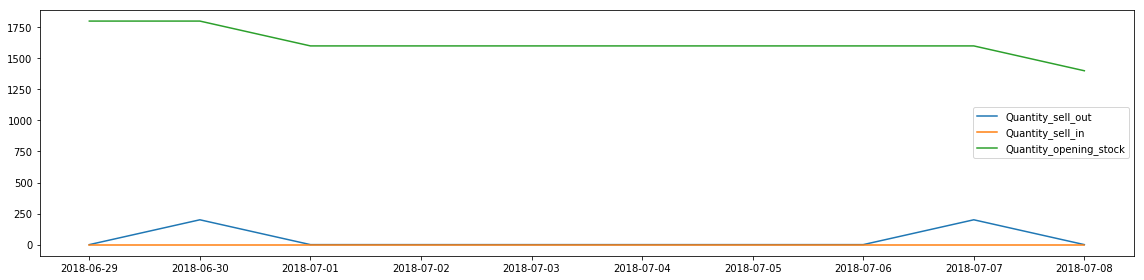

In [42]:
plt.plot(explore.loc[('HU0001/00009', 'A003505')].Quantity_sell_out) # Sell-out for specific retailer and SKU
plt.plot(explore.loc[multi_index].Quantity_sell_in) # Sell-in for the same retailer and SKU, but this time using multi_index selected in the previous step
plt.plot(explore.loc[multi_index, 'Quantity_opening_stock']) # Opening-stock for the same retailer and SKU
plt.tight_layout()
plt.legend();

### Statistics

#### Counts

In [43]:
# Unique retailers
unique_levels = np.unique(explore.index.get_level_values('Retailer'))
print("Number of unique retailers:", len(unique_levels), "and they are:\n", unique_levels)

Number of unique retailers: 5786 and they are:
 ['HU0001/00009' 'HU0001/00017' 'HU0001/00041' ... 'RT/HU2954/1'
 'RT/HU3038/1' 'RT/HU3111/1']


#### Aggregates

##### Retailer * SKU acorss dates

In [44]:
# Aggregate sell_in and sell_out for retailer * SKU across dates
explore.groupby(level=['Retailer','SKU'])[['Quantity_sell_in', 'Quantity_sell_out']].agg(['sum']).head()

Quantity_sell_in Quantity_sell_out
                                  sum               sum
Retailer     SKU                                       
HU0001/00009 A003505              0.0             400.0
             A004283              0.0             200.0
             A004318              0.0             600.0
             A004483              0.0               0.0
             A004485              0.0             200.0

In [45]:
# Aggregate sell_out for retailer * SKU across dates
explore_agg = explore.groupby(level=['Retailer','SKU'])[['Quantity_sell_out']].agg(['sum']).loc[:, 'Quantity_sell_out']

# Sort
explore_agg.sort_values(by=['sum'], ascending=False, inplace=True)
print(explore_agg.head(10), "\n---\n")

# Top 10 combinations
top_combinations_index = explore_agg.index.get_values()[:10]
print(top_combinations_index, "\n---\n")

# Select the top combination
print(explore.loc[top_combinations_index[0]], "\n---\n")

# Select top 10 combinations in the aggregated dataframe
explore_agg.loc[list(top_combinations_index)]

                           sum
Retailer     SKU              
HU0396/00069 A005656  117880.0
HU0235/00015 A005381   60250.0
HU0097/00001 A005381   58900.0
HU0251/00049 A005381   47700.0
             A004868   42000.0
HU1420/00007 A004868   37650.0
HU0235/00019 A005381   37300.0
HU1437/00025 A005381   35100.0
HU0299/00002 A005381   33250.0
HU0235/00015 A004868   28050.0 
---

[('HU0396/00069', 'A005656') ('HU0235/00015', 'A005381')
 ('HU0097/00001', 'A005381') ('HU0251/00049', 'A005381')
 ('HU0251/00049', 'A004868') ('HU1420/00007', 'A004868')
 ('HU0235/00019', 'A005381') ('HU1437/00025', 'A005381')
 ('HU0299/00002', 'A005381') ('HU0235/00015', 'A004868')] 
---

            Quantity_opening_stock  Quantity_sell_in  Quantity_sell_out
Date                                                                   
2018-06-29                     0.0           25000.0            69400.0
2018-07-02                     0.0               0.0            11800.0
2018-07-03                     0.0        

sum
Retailer     SKU              
HU0396/00069 A005656  117880.0
HU0235/00015 A005381   60250.0
HU0097/00001 A005381   58900.0
HU0251/00049 A005381   47700.0
             A004868   42000.0
HU1420/00007 A004868   37650.0
HU0235/00019 A005381   37300.0
HU1437/00025 A005381   35100.0
HU0299/00002 A005381   33250.0
HU0235/00015 A004868   28050.0

##### Retailer across dates

In [46]:
# Aggregate sell_out for retailer across dates
explore_agg = explore.groupby(level=['Retailer'])[['Quantity_sell_out']].agg(['sum']).loc[:, 'Quantity_sell_out']

# Sort
explore_agg.sort_values(by=['sum'], ascending=False, inplace=True)

# Top 10 retailers
top_retailers_index = explore_agg.index[:10]
print(top_retailers_index, "\n---\n")

# Select the top retailer
print(explore.loc[top_retailers_index[0]].head(), "\n---\n")

# Select the top 10 retailers
print(explore.loc[list(top_retailers_index)].head())

Index(['HU2479/00025', 'HU2479/00189', 'HU2479/00021', 'HU1004/00008',
       'HU1487/00014', 'HU2479/00022', 'HU0251/00049', 'HU1450/00006',
       'HU0097/00001', 'HU2479/00096'],
      dtype='object', name='Retailer') 
---

                    Quantity_opening_stock  Quantity_sell_in  \
SKU     Date                                                   
A003505 2018-06-29                  4000.0            1000.0   
        2018-06-30                  5000.0               0.0   
        2018-07-01                  5000.0               0.0   
        2018-07-02                  4600.0               0.0   
        2018-07-03                  4600.0               0.0   

                    Quantity_sell_out  
SKU     Date                           
A003505 2018-06-29                0.0  
        2018-06-30                0.0  
        2018-07-01              400.0  
        2018-07-02                0.0  
        2018-07-03                0.0   
---

                                 Quant

##### SKU acorss dates

In [47]:
# Aggregate sell_out for SKU across dates
explore_agg = explore.groupby(level=['SKU'])[['Quantity_sell_out']].agg(['sum']).loc[:, 'Quantity_sell_out']

# Sort
explore_agg.sort_values(by=['sum'], ascending=False, inplace=True)

# Top 10 SKUs
top_skus_index = explore_agg.index[:10]
print(top_skus_index, "\n---\n")

# Select the top SKU
print(explore.loc[(slice(None), top_skus_index[0]), :].head(), "\n---\n")

# Select top 10 SKUs
print(explore.loc[(slice(None), list(top_skus_index)), :].head())

Index(['A005381', 'A004868', 'A004318', 'A005477', 'A005453', 'A006310',
       'A005470', 'A005462', 'A005472', 'A005471'],
      dtype='object', name='SKU') 
---

                                 Quantity_opening_stock  Quantity_sell_in  \
Retailer     SKU     Date                                                   
HU0001/00009 A005381 2018-06-29                  1800.0               0.0   
                     2018-06-30                  1750.0               0.0   
                     2018-07-01                  1650.0               0.0   
                     2018-07-02                  1550.0               0.0   
                     2018-07-03                  1400.0               0.0   

                                 Quantity_sell_out  
Retailer     SKU     Date                           
HU0001/00009 A005381 2018-06-29               50.0  
                     2018-06-30              100.0  
                     2018-07-01              100.0  
                     2018-07-0

In [48]:
# Select top 10 Retailers and top 10 SKUs
print(explore.loc[(list(top_retailers_index), list(top_skus_index)), :].head())

                                 Quantity_opening_stock  Quantity_sell_in  \
Retailer     SKU     Date                                                   
HU0097/00001 A004318 2018-06-29                  9800.0               0.0   
                     2018-06-30                  9800.0               0.0   
                     2018-07-01                  9800.0               0.0   
                     2018-07-02                  9800.0               0.0   
                     2018-07-03                  9800.0               0.0   

                                 Quantity_sell_out  
Retailer     SKU     Date                           
HU0097/00001 A004318 2018-06-29                0.0  
                     2018-06-30                0.0  
                     2018-07-01                0.0  
                     2018-07-02                0.0  
                     2018-07-03                0.0  


##### Month-wise

In [49]:
# Dates for all the rows
print(explore.index.get_level_values('Date'), "\n---\n")

# Select a particular month
print(explore.iloc[explore.index.get_level_values('Date').month == 7].head(), "\n---\n")

# Select a particular retailer on a select month
explore.iloc[explore.index.get_level_values('Date').month == 7].loc[('HU0001/00009')].head()

DatetimeIndex(['2018-06-29', '2018-06-30', '2018-07-01', '2018-07-02',
               '2018-07-03', '2018-07-04', '2018-07-05', '2018-07-06',
               '2018-07-07', '2018-07-08',
               ...
               '2018-06-29', '2018-06-30', '2018-07-01', '2018-07-02',
               '2018-07-03', '2018-07-04', '2018-07-05', '2018-07-06',
               '2018-07-07', '2018-07-08'],
              dtype='datetime64[ns]', name='Date', length=2808598, freq=None) 
---

                                 Quantity_opening_stock  Quantity_sell_in  \
Retailer     SKU     Date                                                   
HU0001/00009 A003505 2018-07-01                  1600.0               0.0   
                     2018-07-02                  1600.0               0.0   
                     2018-07-03                  1600.0               0.0   
                     2018-07-04                  1600.0               0.0   
                     2018-07-05                  1600.0         

Quantity_opening_stock  Quantity_sell_in  \
SKU     Date                                                   
A003505 2018-07-01                  1600.0               0.0   
        2018-07-02                  1600.0               0.0   
        2018-07-03                  1600.0               0.0   
        2018-07-04                  1600.0               0.0   
        2018-07-05                  1600.0               0.0   

                    Quantity_sell_out  
SKU     Date                           
A003505 2018-07-01                0.0  
        2018-07-02                0.0  
        2018-07-03                0.0  
        2018-07-04                0.0  
        2018-07-05                0.0

In [50]:
# Aggregate sell_out for SKU in a particular month
explore_monthly = explore.iloc[explore.index.get_level_values('Date').month == 7]
explore_agg = explore_monthly.groupby(level=['SKU'])[['Quantity_sell_out']].agg(['sum']).loc[:, 'Quantity_sell_out']

# Sort
explore_agg.sort_values(by=['sum'], ascending=False, inplace=True)

# Top 10 SKUs in a particular month
top_skus_index = explore_agg.index[:10]
print(top_skus_index, "\n---\n")

# Select the top SKU in a particular month, across the entire time
print(explore.loc[(slice(None), top_skus_index[0]), :].head(), "\n---\n")

# Select top 10 SKUs in a particular month, across the entire time
print(explore.loc[(slice(None), list(top_skus_index)), :].head())

Index(['A005381', 'A004868', 'A004318', 'A005477', 'A005453', 'A006310',
       'A005462', 'A005470', 'A005472', 'A005471'],
      dtype='object', name='SKU') 
---

                                 Quantity_opening_stock  Quantity_sell_in  \
Retailer     SKU     Date                                                   
HU0001/00009 A005381 2018-06-29                  1800.0               0.0   
                     2018-06-30                  1750.0               0.0   
                     2018-07-01                  1650.0               0.0   
                     2018-07-02                  1550.0               0.0   
                     2018-07-03                  1400.0               0.0   

                                 Quantity_sell_out  
Retailer     SKU     Date                           
HU0001/00009 A005381 2018-06-29               50.0  
                     2018-06-30              100.0  
                     2018-07-01              100.0  
                     2018-07-0

### Delete temporary dataframes

In [51]:
del(explore)
del(explore_agg)
del(explore_monthly)